<a href="https://colab.research.google.com/github/TZstatsADS/ads-spring-2022-prj4-group-9-1/blob/main/doc/DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Introduction of the Problem:

## DM model explained :

## Loading the used packages

In [2]:
#Loading the desired packages
!pip install dccp
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cvxpy as cp
import dccp
import matplotlib.pyplot as plt

  Created wheel for dccp: filename=dccp-1.0.4-py3-none-any.whl size=7386 sha256=f303e782fffafc01b83df7b1a575fb35e88aeb6a5bc1554e6e4e8d07f317c2d2
  Stored in directory: /root/.cache/pip/wheels/44/a0/2b/8944fc49959e6ae8cc9584719c236016c214a04baf6516e24d
Successfully built dccp


# 1. Data Processing:


## Loading the data:

In [ ]:
data = pd.read_csv("/content/data/compas-scores-two-years.csv")
data

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


## Selecting the relevant features :

In [ ]:
# Select only Caucasian and African-American as our sensitive feature
data = data[data["race"].isin(["Caucasian","African-American"])]

In [ ]:
# Select the features to predict the target y
X = data[["sex","age_cat","priors_count.1","race"]]
y = data["two_year_recid"]

# Encode the categorical_features
for categorical_feature in ["sex","age_cat","race"]:
  categorical_variable = pd.get_dummies(X[categorical_feature]).iloc[:,0]
  X = pd.concat([X,categorical_variable],axis=1)
  X = X.drop(categorical_feature,axis=1)
  X = X.rename(columns={list(X)[-1]:categorical_feature})

## Constructing our training and test set:

In [ ]:
# Construct the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=42)

# 2. Implementing the Fairness model :

## Defining the logistic loss:

In [493]:
from sklearn.utils.extmath import weighted_mode

def logistic_loss(X,y,weight):
  '''
      Compute the logistic loss using the data set [X,y]

      Parameters
      ----------
      X : arrays
        Training features
      y : arrays 
        Training target
      weight : array of size num_features
        The weight of our logistic regression model
  '''
  return 1/len(X)*cp.sum(cp.logistic(X @ weight)-cp.multiply(y,X @ weight))

## Implementing the DM model:

In [494]:
class boundary_decision:
  ''' 
      This class compute the boundary decision as
      defined in the paper for different decision

      ...

      Parameters :
      ------------

      decision : str
          name of the missclassification measure tackled
          choice in ("OMR","FPR","FNR")
  '''

  def __init__(self, decision="OMR"):
    self.decision = decision

  def __call__(self,X,y, weight):
    '''
    Return the boundary decision (g_theta in the paper) according to the 
    missclassification measure we want to tackled

    Parameters :
    ------------
    X : arrays
        Training features
    y : arrays 
        Training target
    weight : array of size num_features
        The weight of our logistic regression model
    '''
    if self.decision == "OMR":
      return cp.minimum(0, cp.multiply(y,(X @ weight)))
    if self.decision == "FPR":
      return cp.minimum(0, cp.multiply((1-y)*(2*y-1),(X @ weight)))
    if self.decision == "FNR":
      return cp.minimum(0, cp.multiply(y*(2*y-1),(X @ weight)))
  
  def convexified(self,X,y, weight, new_weight):
    '''
    Return the linearized boundary decision around an input weight according to the 
    missclassification measure we want to tackled

    Parameters :
    ------------
    X : arrays
        Training features
    y : arrays 
        Training target
    weight : array of size num_features
        The weight around which the boundary decision is
        linearized
    new_weight : array of size num_features
        The weight in which we want to evaluate the 
        convexified boundary decision
    '''
    if self.decision == "OMR":
      dirac = y*(X @ weight)>=0
      return self(X,y,weight)+cp.multiply(y*dirac,(X @ (new_weight-weight)))

    if self.decision == "FPR":
      dirac = (1-y)*(2*y-1)*(X @ weight)<=0
      return self(X,y,weight)+cp.multiply(dirac*(1-y)*(2*y-1),X @ (new_weight-weight))
      
    if self.decision == "FNR":
      dirac = y*(2*y-1)*(X @ weight) <=0
      return self(X,y,weight)+ cp.multiply(dirac*y*(2*y-1),X @ (new_weight-weight))

In [3]:
class DM:
    ''' 
        This class compute a default solver 
        to get train a classifier without disparate treatment.
        Only logistic classifier was implemented yet but new implementation
        can be seen by changing the loss.

        ...

        Parameters :
        ------------

        X : arrays
            Training features
        y : arrays 
            Training target
        weight : array of size num_features
            Initial weight of our logistic regression model
        method : str
            name of the missclassification measure tackled
            choice in ("OMR","FPR","FNR")
        
        Hyperparameters :
        ------------
        c : float
            Lower-upper bound of the constraint in the DM formulation
        tau : float
            Initial penalization constant of the slack variables in the CCP solver
        mu : float
            At each iteration of the solver, we increase tau by tau*mu
    '''

    def __init__(self, X, y, weight=np.zeros(4), c=0.1, tau=0.1, mu=1.1, method="OMR"):
      self.X = X
      self.y = y
      self.c = cp.Parameter(value=c)
      self.weight = weight
      self.si = cp.Variable(2,nonneg=True)
      self.tau = tau
      self.history = []
      self.weight_k = cp.Variable(4, value = weight)
      self.z = X[:,-1]
      self.g = boundary_decision(method)

    def solve_subproblem(self):
      '''
      This function is call by the CCP solver build from scratch.
      Solve the subproblem as defined in the CCP solver.
      '''
      N = len(X[:,-1])
      N1 = sum(X[:,-1])
      N0 = N-N1
      constraints = [
               -N1/N*cp.sum(cp.multiply(self.z==0,self.g(self.X,self.y,self.weight_k)))+ N0/N*cp.sum(cp.multiply(self.z==1,self.g.convexified(self.X,self.y,self.weight,self.weight_k)))<=self.c+self.si[0],
               -N0/N*cp.sum(cp.multiply(self.z==1,self.g(self.X,self.y,self.weight_k)))+ N1/N*cp.sum(cp.multiply(self.z==0,self.g.convexified(self.X,self.y,self.weight,self.weight_k)))<=self.c+self.si[1]
               ]
      loss = logistic_loss(self.X,self.y)(self.weight_k)
      obj = cp.Minimize(loss+self.tau*cp.sum(self.si))
      prob = cp.Problem(obj,constraints=constraints)
      res = prob.solve(warm_start = True)
      print(prob.status)
      self.history.append(res)
    
    def predict(self,X_test):
      '''
      Compute the prediction of our logistic regression model using
      the resulting weights.

      Parameters :
      -----------
      X_test : array
          New set of features on which we make our prediction
      '''
      prob = np.exp(X_test @ self.weight_k.value)/(1+np.exp(X_test @ self.weight_k.value))
      return np.vectorize(lambda p: int(p>=0.5))(prob)
    
    def accuracy(self, X_val, y_val):
      '''
      Return the accuracy of our model by computing
      the average number of TRP and FRP over the 
      data set [X_val, y_val]

      Parameters : 
      -------------
      X_val : array
          Set of features on which we want to evaluate the accuracy
          of our model
      y_val : array
          The target we are trying to reach when evaluating our model
      '''
      y_hat  = self.predict(X_val)
      return np.sum(y_hat==y_val)/len(y_val)


    def solve(self,T):
      '''
      CCP solver build from scratch based on the proposed algorithm

      Parameters :
      -------------
      T : int
          Number of iteration the solver is run.
          Should we replace it by a termination criterion ?
      '''
      for i in range(T):
        # We split the data into a training and validation set at each step
        self.X, X_val, self.y, y_val = train_test_split(self.X,self.y,test_size=1/7)
        self.z = X[:,-1]
        self.solve_subproblem()
        self.tau = np.minimum(self.tau*1.1,1)
        self.weight = self.weight_k.value
        print("epoch {} - accuracy {:.3f} - val_accuracy {:.3f}".format(i,self.accuracy(self.X,self.y), self.accuracy(X_val,y_val)))
        self.X = np.concatenate([self.X,X_val])
        self.y = np.concatenate([self.y,y_val])
      
    def solve_DCCP(self):
      '''
      Solve the DM formulation using the DCCP package
      '''
      self.X, X_val, self.y, y_val = train_test_split(self.X,self.y,test_size=1/7)
      self.z = X[:,-1]
      N = len(X[:,-1])
      N1 = sum(X[:,-1])
      N0 = N-N1
      constraints = [
               -N1/N*cp.sum(cp.multiply(self.z==0,self.g(self.X,self.y,self.weight_k)))<=self.c - N0/N*cp.sum(cp.multiply(self.z==1,self.g(self.X,self.y,self.weight_k))),
               -N0/N*cp.sum(cp.multiply(self.z==1,self.g(self.X,self.y,self.weight_k)))<=self.c - N1/N*cp.sum(cp.multiply(self.z==0,self.g(self.X,self.y,self.weight_k)))
               ]
      loss = logistic_loss(self.X,self.y)(self.weight_k)
      obj = cp.Minimize(loss)
      prob = cp.Problem(obj,constraints=constraints)
      result = prob.solve(method='dccp', warm_start=True)
      print(prob.status)
      print("accuracy {:.3f} - val_accuracy {:.3f}".format(self.accuracy(self.X,self.y), self.accuracy(X_val,y_val)))
      self.X = np.concatenate([self.X,X_val])
      self.y = np.concatenate([self.y,y_val])


In [ ]:
solver = DM(X_train.to_numpy(),y_train.to_numpy())

In [ ]:
solver.solve(10)

optimal
epoch 0 - accuracy 0.500 - val_accuracy 0.517
optimal
epoch 1 - accuracy 0.566 - val_accuracy 0.578
optimal
epoch 2 - accuracy 0.576 - val_accuracy 0.562
optimal
epoch 3 - accuracy 0.606 - val_accuracy 0.572
optimal
epoch 4 - accuracy 0.592 - val_accuracy 0.614
optimal
epoch 5 - accuracy 0.598 - val_accuracy 0.591
optimal
epoch 6 - accuracy 0.597 - val_accuracy 0.590
optimal
epoch 7 - accuracy 0.595 - val_accuracy 0.604
optimal
epoch 8 - accuracy 0.598 - val_accuracy 0.576
optimal
epoch 9 - accuracy 0.599 - val_accuracy 0.588


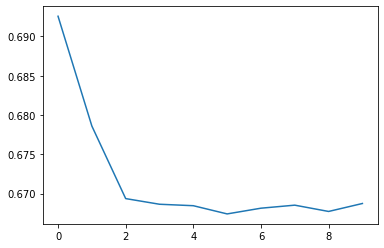

In [ ]:
plt.plot(solver.history)

In [ ]:
solver.solve_DCCP()

Converged
accuracy 0.595 - val_accuracy 0.587


In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42).fit(X_train,y_train)
model.score(X_test,y_test)

0.6313993174061433